In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
project_name = '05b-cifar10-resnet'

In [ ]:
from torchvision.datasets.utils import download_url

# Downloading the dataset
dataset_url = "http://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url = download_url(dataset_url,'.')

# Extracting from archive
with tarfile.open('./cifar10.tgz','r:gz') as tar:
  tar.extractall(path='./data')


100%|██████████| 135107811/135107811 [00:03<00:00, 35216350.32it/s]


In [ ]:
# Looking into the data dictionary
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['bird', 'horse', 'cat', 'dog', 'airplane', 'ship', 'truck', 'automobile', 'frog', 'deer']


We will use the whole test set as the validation set. Its good to train the data again as a whole in training set as this gives us an extra boost in performance

Channel -wise data normalization: We will also normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the dataset across each chaneel is 0, and the standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values then others

Randomized Data Augmentation: We will apply randomly chosen transformation while loading the images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it to generalize better.

In [ ]:
# Data Transforms (normalization and data augmentation)
# stats = ((mean of red),(mean of green),(mean of blue)) , ((Standard deviation of red),(Standard deviation of green),(Standard deviation of blue))
# tt is torchvision.ToTransform
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
             tt.RandomHorizontalFlip(),
            # tt.RandomRotate
            # tt.RandomResizedCrop(256, scale = (0.5,0.9), ratio = (1,1))
            # tt.ColorJitter((brightness=0.1, contrast = 0.1, saturation = 0.1,))
            tt.ToTensor(), # This is going to take the transformed images to pytorch Tensors
            tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [ ]:
# PyTorch Datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [ ]:
batch_size = 400

In [ ]:
# Pytorch DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Lets take a look at some sample images from sample images from the training DataLoader. To display the images, we will need to denormalize the pixels values and bring back into the range (0,1)

In [ ]:
def denormalize(images,means,stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(means).reshape(1,3,1,1)
  return images * stds + means

def show_batch(dl):
  for images,labels in dl:
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xticks([]);
    ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow = 8).permute(1,2,0).clamp(0,1))
    break

<ipython-input-9-e62cfa3156c8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds = torch.tensor(means).reshape(1,3,1,1)


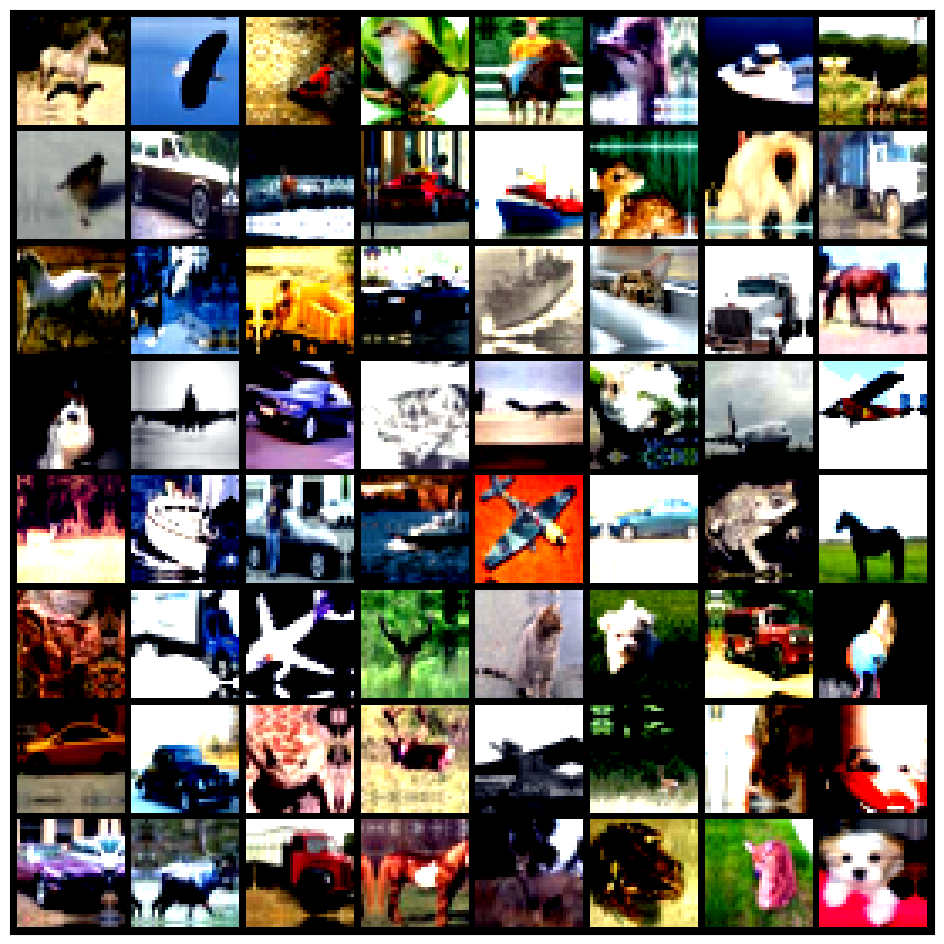

In [ ]:
show_batch(train_dl)

**Using a GPU**

we will define a couple of helper functions

1.   get_default_device
2.   to_device

and a helper class:

1.   DeviceDataLoader





In [ ]:
def get_default_device():
  """ Pick GPU if available or CPU if not """
  if torch.cuda.is_available():
     return torch.device('cuda')
  else:
     return torch.device('cpu')

def to_device(data, device):
  """ Move tensor(s) to chosen device """
  if isinstance(data,(list,tuple)):
    # for x in data:
    #     return to_device(x,data)
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """ Wrap a dataLoader to move data to a device """
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yield a batch of data after moving it to device """
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """ Number of batches """
    return self.dl.__len__()


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# **Model with residual blocks and Batch Normalization**
One of the key changes to our CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layer
By calculating the residual, you make the model more powerful as the residual block needs to be calculated rather then each output of the layers

In [ ]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding =1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out)
    return self.relu2(out) + x # ReLU can be applied before or after adding the input

# We cannot change the no. of channel in the residul block or else will not be able to add the input to the output as the input shape and output shape would not match and it will not be compatible tensor addition

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  print(images.shape)
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


After each convolutional layer, we will also add a batch normalization layer, which normalizes the outputs of the previous layers

>



# We will now use the ResNet9 architecture
It has 8 convolutional layers and 1 linear layer

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_accuracy': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['lrs'][-1],result['train_loss'],result['val_loss'],result['val_accuracy']))

In [ ]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    # 3 x 32 x 32
    self.conv1 = conv_block(in_channels, 64) # 64 x 32 x 32
    self.conv2 = conv_block(64,128, pool = True) # 128 x 16 x 16 `
    self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

    self.conv3 = conv_block(128, 256, pool = True) # 256 x 8 x 8
    self.conv4 = conv_block(256, 512, pool = True) # 512 x 4 x 4
    self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                    nn.Flatten(), # 512
                                    nn.Dropout(0.2), # used to avoid overfitting, we randomly take certain elements from our feature map  (randomly pick 20% values that came out of the previous layer and set them to 0), generalizes the data better
                                    nn.Linear(512, num_classes)) # 10

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out


In [ ]:
model = to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Few Statergies we are applying for improvement

1.   Lr scheduling: "One cycle learning rate policy", which involves starting with a low lr and then gradually increasing it batch - by - batch to high lr rate for about 30% of epochs, then gradually decreasing it to a low value for the remaning epochs
2.   Weight Decay: it is another regularization technique which prevents the weight from becoming too large by adding an additional term to the loss function
3.   Gradient Clipping: Apart from layer weights and outputs, it is also helpful to limit the values of the gradient to a small range to prevent undesirable changes to parameters due to large gradient values. This is called gradient clipping.

Lets define a 'fit_one_cycle' function to incorporate these changes. We will also record the learning rate used for each batch


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval() # Tells the model that we are currently evaluating and not training
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
  torch.cuda.empty_cache() # Removes existing tensors that are not being used in the memory
  history = []

  # set up custom optimizer with weight decay
  optimizer =  opt_func(model.parameters(), max_lr, weight_decay = weight_decay)

  # set up one cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))

  for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()

      # Record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

   # Validation Phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history




In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3073043823242188, 'val_accuracy': 0.054711535573005676}]

# Training the model now
We will use Adam rather then SGD as Adam optimizer uses techniques such momentum and adaptive learning rates for faster training

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip = grad_clip,
                         weight_decay = weight_decay,
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5416, val_loss: 1.4037, val_acc: 0.5559
Epoch [1], last_lr: 0.00935, train_loss: 1.0832, val_loss: 1.3254, val_acc: 0.5874
Epoch [2], last_lr: 0.00972, train_loss: 0.8501, val_loss: 1.2760, val_acc: 0.6138
Epoch [3], last_lr: 0.00812, train_loss: 0.6424, val_loss: 0.7236, val_acc: 0.7631
Epoch [4], last_lr: 0.00556, train_loss: 0.5100, val_loss: 0.5226, val_acc: 0.8277
Epoch [5], last_lr: 0.00283, train_loss: 0.3923, val_loss: 0.4183, val_acc: 0.8599
Epoch [6], last_lr: 0.00077, train_loss: 0.3003, val_loss: 0.3194, val_acc: 0.8889
Epoch [7], last_lr: 0.00000, train_loss: 0.2216, val_loss: 0.2915, val_acc: 0.9009
CPU times: user 21.3 s, sys: 4.22 s, total: 25.5 s
Wall time: 5min 2s


In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_accuracy'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title("Accuracy vs No. of Epochs")

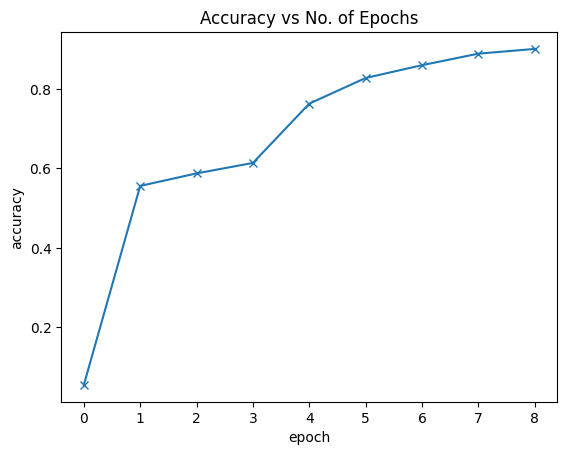

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title("Loss vs No. of Epochs")

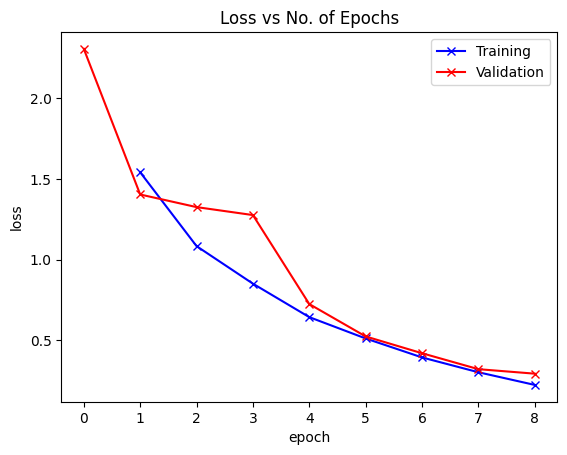

In [ ]:
plot_losses(history)